**Model Skeleton**

Click [here](https://docs.google.com/document/d/1v8xBxDOmItnDbMlbNnb4KsY-F7_jp1F9RJ-aIMr2KHA/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [1]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm
import os, subprocess


import os
import shutil
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from PIL import Image
import pandas as pd
import re
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import struct
import numpy as np
from torch.nn.functional import pad
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import Counter


# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# 0. Variables from your unzipping script
# These should match what you used for unzipping
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip' # Source ZIP on Drive
extract_dir = '/content/Patches_Apr27' # Local extraction directory

In [4]:
import os
from google.colab import drive
import shutil

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [5]:
#Create train, test, and val lists

train_test_val_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")

train_list = train_test_val_df[train_test_val_df.Data == "Train"].Case.to_list()
test_list = train_test_val_df[train_test_val_df.Data == "Test"].Case.to_list()
val_list = train_test_val_df[train_test_val_df.Data == "Validate"].Case.to_list()

In [6]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
sox10_CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths_sox10.csv",  # Explicitly local
    'batch_size': 2,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 10, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    # 'num_workers': 8, # You have num_workers defined twice, choose one. Using 4 from above.
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'sox10'
}

# Combine all cases from train/val/test for the initial full metadata scan
sox10_cases_for_scan = set(sox10_CONFIG['train_cases'] + sox10_CONFIG['test_cases'] + sox10_CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(sox10_cases_for_scan)}")
print(f"Target stain for this run: {sox10_CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {sox10_CONFIG['local_image_folder']}") # Verify local path
if sox10_CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: sox10
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


In [7]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
he_CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths_he.csv",  # Explicitly local
    'batch_size': 2,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 10, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    # 'num_workers': 8, # You have num_workers defined twice, choose one. Using 4 from above.
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'h&e'
}

# Combine all cases from train/val/test for the initial full metadata scan
he_cases_for_scan = set(he_CONFIG['train_cases'] + he_CONFIG['test_cases'] + he_CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(he_cases_for_scan)}")
print(f"Target stain for this run: {he_CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {he_CONFIG['local_image_folder']}") # Verify local path
if he_CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: h&e
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


In [8]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
melan_CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths_melan.csv",  # Explicitly local
    'batch_size': 2,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 10, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    # 'num_workers': 8, # You have num_workers defined twice, choose one. Using 4 from above.
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'melan'
}

# Combine all cases from train/val/test for the initial full metadata scan
melan_cases_for_scan = set(melan_CONFIG['train_cases'] + melan_CONFIG['test_cases'] + melan_CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(melan_cases_for_scan)}")
print(f"Target stain for this run: {melan_CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {melan_CONFIG['local_image_folder']}") # Verify local path
if melan_CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: melan
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


**Note** – the ```n_buckets``` input for our bucketing logic is not included in the CONFIG. You'll have to manually change it the code chunk where we create the boundaries and data loaders (see below in section 6). The default is just to keep ```n_buckets``` = number of batches.

**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [9]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).
    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            # Check if path exists before scanning
            if not os.path.exists(path):
                print(f"⚠️ Directory not found: {path}. Skipping scan for this path.")
                return [] # Return empty iterator if path doesn't exist

            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path) # Recursive call
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts due to OSError: {e}")
        except FileNotFoundError: # Explicitly handle FileNotFoundError during scandir
             print(f"⚠️ Directory not found during scandir: {path}. Skipping.")
             return []
    return scan_dir(root)

In [10]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                # Ensure width/height are numeric for filtering, coerce errors to NaN then fill with -1
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)

                df = df[((df.width  >= min_width) & (df.width  <= max_width)) | (df.width  == -1)] # inclusive min/max
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                if not df.empty:
                     # CRITICAL: Verify that paths are what you expect (local paths)
                    print(f"Example path from loaded metadata: {df['path'].iloc[0]}")
                return df
        except Exception as e:
            print(f"❗ Error loading or filtering {meta_csv}: {e}; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder for scanning does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder} or its subdirectories.")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def proc(p):
        # p will be a full local path like /content/Patches_Apr27/case_001_match_xyz.png
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))

        if cid not in all_cases:
            return None
        if stain.lower() not in p.lower(): # Simple substring check for stain in path
            return None

        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not standard PNG header or IHDR not where expected
                with Image.open(p) as img:
                    w, h = img.size
        except Exception as e:
            # print(f"Warning: Could not get dimensions for {p}: {e}")
            pass # Keep w,h as -1

        # size filter (inclusive)
        if w != -1 and not (min_width <= w <= max_width and min_width <= h <= max_width):
            return None

        return {
            'path': p, # This path is now a local path
            'case_number': cid,
            'stain': stain.lower(), # Store the target stain
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Processing files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}' after filtering. Check scan and filters.")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    if not df.empty:
        print(f"Example path from NEWLY BUILT metadata: {df['path'].iloc[0]}")
    return df

In [11]:
# create metadata
full_meta_df_melan = build_metadata(
    image_folder=melan_CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=melan_cases_for_scan,
    meta_csv=melan_CONFIG['meta_csv_full_scan'],
    stain=melan_CONFIG['target_stain'],
    force_rebuild=melan_CONFIG['force_rebuild_metadata_full'],
    min_width=melan_CONFIG['min_image_size'],
    max_width=melan_CONFIG['max_image_size'],
    num_workers=melan_CONFIG['num_workers']
)

full_meta_df_sox10 = build_metadata(
    image_folder=sox10_CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=sox10_cases_for_scan,
    meta_csv=sox10_CONFIG['meta_csv_full_scan'],
    stain=sox10_CONFIG['target_stain'],
    force_rebuild=sox10_CONFIG['force_rebuild_metadata_full'],
    min_width=sox10_CONFIG['min_image_size'],
    max_width=sox10_CONFIG['max_image_size'],
    num_workers=sox10_CONFIG['num_workers']
)

full_meta_df_he = build_metadata(
    image_folder=he_CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=he_cases_for_scan,
    meta_csv=he_CONFIG['meta_csv_full_scan'],
    stain=he_CONFIG['target_stain'],
    force_rebuild=he_CONFIG['force_rebuild_metadata_full'],
    min_width=he_CONFIG['min_image_size'],
    max_width=he_CONFIG['max_image_size'],
    num_workers=he_CONFIG['num_workers']
)



🔍 Scanning /content/Patches_Apr27 for stain='melan'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:01<00:00, 37529.21it/s]


✅ Built & saved 18657 rows to /content/metadata_full_scan_local_paths_melan.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_24_unmatched_9_melan_patch51.png
🔍 Scanning /content/Patches_Apr27 for stain='sox10'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:01<00:00, 46665.60it/s]


✅ Built & saved 15614 rows to /content/metadata_full_scan_local_paths_sox10.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_066_match_1_sox10_patch79.png
🔍 Scanning /content/Patches_Apr27 for stain='h&e'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:03<00:00, 23620.72it/s]


✅ Built & saved 30255 rows to /content/metadata_full_scan_local_paths_he.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_26_unmatched_3_h&e_patch49.png


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [12]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(melan_CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {melan_CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(melan_CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [13]:
# ─── TRANSFORMS (Adaptive Pooling Approach) ───────────────────────────
# These transforms are applied to individual images by the Dataset's __getitem__.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Example augmentation
    #transforms.RandomRotation(15), # Example augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Example augmentation
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

eval_transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [14]:
# --- Corrected PatchDataset Class ---
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        # THIS LINE MUST EXECUTE BEFORE you try to access self.samples
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

        # NOW it's safe to print the length of self.samples
        print(f"DEBUG: Dataset initialized with {len(self.samples)} total samples.")

    def __len__(self) -> int:
        return len(self.samples)
    def __getitem__(self, idx: int):
            # The IndexError traceback means this 'idx' is out of range for 'self.samples'
            # The primary fix for that is ensuring __len__ and __init__ are correct
            # This print will help verify if it's still being called with bad indices
            # print(f"DEBUG: __getitem__ called with idx = {idx}. len(self.samples) = {len(self.samples)}")

            # Ensure idx is within bounds. If this check triggers, the problem is in __len__ or DataLoader
            if not (0 <= idx < len(self.samples)):
                raise IndexError(f"__getitem__ called with invalid index {idx}. Valid range is [0, {len(self.samples)-1}]")

            path, label = self.samples[idx] # This is the line that errors

            try:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                cid = int(case_pat.search(os.path.basename(path)).group(1))
                return img, label, cid
            except Exception as e:
                # --- CRITICAL FIX HERE ---
                # DO NOT return None. Instead, log the error and re-raise it.
                # This will force the DataLoader to stop at the first genuinely problematic image file.
                print(f"ERROR: Failed to load or process image at index {idx} from path: '{path}'. Error: {e}")
                raise # Re-raise the exception to stop execution and debug the root cause

In [15]:
# --- Splitting metadata and creating datasets ---
# (Small modifications to handle potentially empty full_meta_df)
if not full_meta_df_melan.empty:
    melan_train_meta = full_meta_df_melan[full_meta_df_melan['case_number'].isin(melan_CONFIG['train_cases'])].reset_index(drop=True)
    melan_val_meta   = full_meta_df_melan[full_meta_df_melan['case_number'].isin(melan_CONFIG['validation_cases'])].reset_index(drop=True)
    melan_test_meta  = full_meta_df_melan[full_meta_df_melan['case_number'].isin(melan_CONFIG['test_cases'])].reset_index(drop=True)

    if melan_train_meta.empty or melan_val_meta.empty or melan_test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    melan_train_dataset = PatchDataset(melan_train_meta, labels_map, transform=train_transform)
    melan_val_dataset   = PatchDataset(melan_val_meta, labels_map, transform=eval_transform)
    melan_test_dataset  = PatchDataset(melan_test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(melan_train_dataset)}")
    print(f"✅ Val patches: {len(melan_val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(melan_test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error


if not full_meta_df_sox10.empty:
    sox10_train_meta = full_meta_df_sox10[full_meta_df_sox10['case_number'].isin(sox10_CONFIG['train_cases'])].reset_index(drop=True)
    sox10_val_meta   = full_meta_df_sox10[full_meta_df_sox10['case_number'].isin(sox10_CONFIG['validation_cases'])].reset_index(drop=True)
    sox10_test_meta  = full_meta_df_sox10[full_meta_df_sox10['case_number'].isin(sox10_CONFIG['test_cases'])].reset_index(drop=True)

    if sox10_train_meta.empty or sox10_val_meta.empty or sox10_test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    sox10_train_dataset = PatchDataset(sox10_train_meta, labels_map, transform=train_transform)
    sox10_val_dataset   = PatchDataset(sox10_val_meta, labels_map, transform=eval_transform)
    sox10_test_dataset  = PatchDataset(sox10_test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(sox10_train_dataset)}")
    print(f"✅ Val patches: {len(sox10_val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(sox10_test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error


if not full_meta_df_he.empty:
    he_train_meta = full_meta_df_he[full_meta_df_he['case_number'].isin(he_CONFIG['train_cases'])].reset_index(drop=True)
    he_val_meta   = full_meta_df_he[full_meta_df_he['case_number'].isin(he_CONFIG['validation_cases'])].reset_index(drop=True)
    he_test_meta  = full_meta_df_he[full_meta_df_he['case_number'].isin(he_CONFIG['test_cases'])].reset_index(drop=True)

    if he_train_meta.empty or he_val_meta.empty or he_test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    he_train_dataset = PatchDataset(he_train_meta, labels_map, transform=train_transform)
    he_val_dataset   = PatchDataset(he_val_meta, labels_map, transform=eval_transform)
    he_test_dataset  = PatchDataset(he_test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(he_train_dataset)}")
    print(f"✅ Val patches: {len(he_val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(he_test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error

DEBUG: Dataset initialized with 9705 total samples.
DEBUG: Dataset initialized with 3746 total samples.
DEBUG: Dataset initialized with 4166 total samples.
✅ Train patches: 9705
✅ Val patches: 3746
✅ Test patches: 4166
DEBUG: Dataset initialized with 8141 total samples.
DEBUG: Dataset initialized with 3054 total samples.
DEBUG: Dataset initialized with 3416 total samples.
✅ Train patches: 8141
✅ Val patches: 3054
✅ Test patches: 3416
DEBUG: Dataset initialized with 15667 total samples.
DEBUG: Dataset initialized with 5991 total samples.
DEBUG: Dataset initialized with 7606 total samples.
✅ Train patches: 15667
✅ Val patches: 5991
✅ Test patches: 7606


**6) Data Loader and Helper Functions**


There are 3 code chunks for 3 different helper functions:
- BucketSampler: function behind our bucketing logic. It will group indices of similar-sized images together
- make_boundaries_for_buckets: will calculate and define the actual size boundaries for our batches
- collate_fn_pad: collate functions are used by the DataLoader object to group individual samples into a batch. Our custom function also performs the padding operation within each batch

**Bucketing logic**: Because we have to pad images up to the size of the largest image within each batch, we want to make sure that images within the same batch are of similar sizes. To do this, we will first calculate the total_number_of_batches that will be used per epoch (total images/batch size). Then we will separate the images by width into total_number_of_batches number of bins (e.g. if total_number_of_batches = 40, then there will be 40 bins). Then each of these bins will be a batch and sent separately to be trained on — thus images within the same batch are of very similar sizes and the amount of padding needed is very negligible).

In [16]:

# ─── HELPER: BUCKET BATCH SAMPLER ─────────────────────────────────────
# This Sampler is responsible for the "bucketing" logic.
# It groups indices of similar-sized images together.
class BucketBatchSampler(Sampler):
    """
    Samples batches by grouping indices into buckets based on data source sizes.
    Batches are created from indices within the same bucket.
    """
    def __init__(self, data_source_sizes, batch_size, boundaries, shuffle=True):
        """
        Args:
            data_source_sizes (list): List of sizes (e.g., max dimension after resize) for each item.
            batch_size (int): The desired batch size.
            boundaries (list): A sorted list of size thresholds defining the buckets.
                               An item with size S falls into bucket i if boundaries[i-1] < S <= boundaries[i].
            shuffle (bool): Whether to shuffle indices within buckets and the order of batches.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Create buckets based on boundaries
        bucket_indices = {i: [] for i in range(len(boundaries) + 1)}
        for idx, size in enumerate(data_source_sizes):
            # Determine which bucket the size falls into
            bucket_num = sum(size > b for b in boundaries)
            bucket_indices[bucket_num].append(idx)

        self.batches = []
        # Create batches from indices within each bucket
        for bucket_num in sorted(bucket_indices.keys()):
            indices_in_bucket = bucket_indices[bucket_num]
            if self.shuffle:
                np.random.shuffle(indices_in_bucket)

            for i in range(0, len(indices_in_bucket), batch_size):
                batch = indices_in_bucket[i:i+batch_size]
                if len(batch) > 0:
                    self.batches.append(batch)

        if self.shuffle:
            np.random.shuffle(self.batches)

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

In [17]:
# ─── HELPER: MAKE BUCKET BOUNDARIES (Optimized for N Batches) ─────────
# This helper is used to calculate the boundaries for the buckets.
def make_boundaries_for_buckets(sizes, n_buckets):
    """
    Creates bucket boundaries such that the data is split into approximately
    n_buckets groups of equal size based on the sorted 'sizes'.
    Returns n_buckets - 1 boundaries.
    """
    #if not sizes or n_buckets <= 1:
    if sizes is None or len(sizes) == 0 or n_buckets <= 1:
        return []

    # Convert to pandas Series to use quantile/percentile efficiently
    sizes_series = pd.Series(sizes)
    total_items = len(sizes_series)
    boundaries = []

    # Calculate quantiles to define boundaries
    # We need n_buckets - 1 division points
    quantiles = [(i / n_buckets) for i in range(1, n_buckets)]

    # Calculate the boundary values using quantiles
    # Handle potential errors if quantile calculation fails (e.g., not enough unique sizes)
    try:
        bounds = sizes_series.quantile(quantiles).tolist()
    except Exception:
        # Fallback to simpler percentile calculation if quantile fails
        qs = [100 * i / n_buckets for i in range(1, n_buckets)]
        bounds = np.percentile(sizes, qs).tolist()


    # Ensure boundaries are unique, sorted, and integer
    return sorted(list(set(int(b) for b in bounds)))

In [18]:

import torch
import torchvision.transforms.functional as F_tv
import numpy as np # For potential other data processing, though not strictly needed here

def collate_fn_pad(batch):
    # Separate images, labels, and cids from the batch
    # batch is a list of (img_tensor, label, cid) tuples
    imgs = [item[0] for item in batch]
    lbls = [item[1] for item in batch]
    cids = [item[2] for item in batch]

    # --- Step 1: Determine the maximum height and width within the CURRENT BATCH ---
    max_h_batch = 0
    max_w_batch = 0

    # Iterate through all images in the current batch to find max dimensions
    for img_tensor in imgs:
        # img_tensor.shape is (C, H, W)
        h, w = img_tensor.shape[1], img_tensor.shape[2]
        if h > max_h_batch:
            max_h_batch = h
        if w > max_w_batch:
            max_w_batch = w

    # --- Step 2: Pad each image in the current batch to these determined max dimensions ---
    padded_imgs = []
    for img_tensor in imgs:
        h, w = img_tensor.shape[1], img_tensor.shape[2]

        # Calculate padding amounts for this specific image to reach batch's max_h_batch and max_w_batch
        # We'll pad to the bottom and right for simplicity (left/top padding can be added for centering)
        pad_h_bottom = max_h_batch - h
        pad_w_right = max_w_batch - w

        # The pad function expects padding_left, padding_top, padding_right, padding_bottom
        # For padding to bottom-right, padding_left and padding_top are 0
        padding_amounts = (0, 0, pad_w_right, pad_h_bottom)

        # Apply padding
        padded_img = F_tv.pad(img_tensor, padding_amounts, fill=0) # fill=0 for black padding, or use mean/median
        padded_imgs.append(padded_img)

    # --- Step 3: Stack the padded images ---
    # Now, all tensors in padded_imgs should have identical dimensions (C, max_h_batch, max_w_batch)
    # torch.stack will work correctly.
    return torch.stack(padded_imgs), torch.tensor(lbls, dtype=torch.long), torch.tensor(cids)


In [19]:
# --- Create Samplers and DataLoaders ---
# (Added checks for empty datasets/metadata before creating samplers/loaders)

# Helper function to get filtered meta based on dataset's samples
def get_filtered_meta_for_sampler(original_meta_df, dataset_samples):
    # Get the paths that are actually in the dataset's samples
    dataset_paths = {path for path, _ in dataset_samples}
    # Filter the original meta_df to only include those paths
    filtered_meta = original_meta_df[original_meta_df['path'].isin(dataset_paths)].reset_index(drop=True)
    return filtered_meta

########## HE ##########
# --- TRAIN LOADER ---
if he_train_dataset and not he_train_meta.empty and len(he_train_dataset) > 0:
    # Filter train_meta to match the actual samples in train_dataset
    # This ensures len(filtered_train_meta) == len(train_dataset)
    he_filtered_train_meta = get_filtered_meta_for_sampler(he_train_meta, he_train_dataset.samples)

    he_train_widths = pd.to_numeric(he_filtered_train_meta['width'], errors='coerce').fillna(-1).astype(int)
    he_train_widths = he_train_widths[he_train_widths != -1] # Filter out unknown dimensions for bucket boundaries

    if not he_train_widths.empty:
        he_train_boundaries = make_boundaries_for_buckets(he_train_widths.tolist(), n_buckets=max(1, int(len(he_train_dataset)/he_CONFIG['batch_size'])))
        # Pass the widths from the FILTERED meta for the sampler
        he_train_batch_sampler = BucketBatchSampler(
            he_train_widths.tolist(), # Use the widths from the filtered meta
            batch_size=he_CONFIG['batch_size'],
            boundaries=he_train_boundaries
        )
        he_train_loader = DataLoader(
            he_train_dataset, pin_memory=True, num_workers=0,
            batch_sampler=he_train_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Train DataLoader created with {len(he_train_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create train_loader with buckets. Consider standard DataLoader.")
        train_loader = None # Or fallback to standard DataLoader
else:
    print("❌ Train dataset is empty or metadata missing. Skipping Train DataLoader.")
    train_loader = None

# --- VAL LOADER ---
if he_val_dataset and not he_val_meta.empty and len(he_val_dataset) > 0:
    he_filtered_val_meta = get_filtered_meta_for_sampler(he_val_meta, he_val_dataset.samples)
    he_val_widths = pd.to_numeric(he_filtered_val_meta['width'], errors='coerce').fillna(-1).astype(int)
    he_val_widths = he_val_widths[he_val_widths != -1]
    if not he_val_widths.empty:
        he_val_boundaries = make_boundaries_for_buckets(he_val_widths.tolist(), n_buckets=max(1, int(len(he_val_dataset)/he_CONFIG['batch_size'])))
        he_val_batch_sampler = BucketBatchSampler(
            he_val_widths.tolist(),
            batch_size=he_CONFIG['batch_size'],
            boundaries=he_val_boundaries
        )
        he_val_loader = DataLoader(
           he_val_dataset, pin_memory=True, num_workers=0,
            batch_sampler=he_val_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Validation DataLoader created with {len(he_val_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create val_loader with buckets.")
        val_loader = None
else:
    print("❌ Validation dataset is empty or metadata missing. Skipping Val DataLoader.")
    val_loader = None

# --- TEST LOADER ---
if he_test_dataset and not he_test_meta.empty and len(he_test_dataset) > 0:
    he_filtered_test_meta = get_filtered_meta_for_sampler(he_test_meta, he_test_dataset.samples)
    he_test_widths = pd.to_numeric(he_filtered_test_meta['width'], errors='coerce').fillna(-1).astype(int)
    he_test_widths = he_test_widths[he_test_widths != -1]
    if not he_test_widths.empty:
        he_test_boundaries = make_boundaries_for_buckets(he_test_widths.tolist(), n_buckets=max(1, int(len(he_test_dataset)/he_CONFIG['batch_size'])))
        he_test_batch_sampler = BucketBatchSampler(
            he_test_widths.tolist(), # Use the widths from the filtered meta
            batch_size=he_CONFIG['batch_size'],
            boundaries=he_test_boundaries
        )
        he_test_loader = DataLoader(
            he_test_dataset, pin_memory=True, num_workers=0,
            batch_sampler=he_test_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Test DataLoader created with {len(he_test_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create test_loader with buckets.")
        test_loader = None
else:
    print("❌ Test dataset is empty or metadata missing. Skipping Test DataLoader.")
    test_loader = None

########## sox10 ##########
# --- TRAIN LOADER ---
if sox10_train_dataset and not sox10_train_meta.empty and len(sox10_train_dataset) > 0:
    # Filter train_meta to match the actual samples in train_dataset
    # This ensures len(filtered_train_meta) == len(train_dataset)
    sox10_filtered_train_meta = get_filtered_meta_for_sampler(sox10_train_meta, sox10_train_dataset.samples)

    sox10_train_widths = pd.to_numeric(sox10_filtered_train_meta['width'], errors='coerce').fillna(-1).astype(int)
    sox10_train_widths = sox10_train_widths[sox10_train_widths != -1] # Filter out unknown dimensions for bucket boundaries

    if not sox10_train_widths.empty:
        sox10_train_boundaries = make_boundaries_for_buckets(sox10_train_widths.tolist(), n_buckets=max(1, int(len(sox10_train_dataset)/sox10_CONFIG['batch_size'])))
        # Pass the widths from the FILTERED meta for the sampler
        sox10_train_batch_sampler = BucketBatchSampler(
            sox10_train_widths.tolist(), # Use the widths from the filtered meta
            batch_size=sox10_CONFIG['batch_size'],
            boundaries=sox10_train_boundaries
        )
        sox10_train_loader = DataLoader(
            sox10_train_dataset, pin_memory=True, num_workers=0,
            batch_sampler=sox10_train_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Train DataLoader created with {len(sox10_train_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create train_loader with buckets. Consider standard DataLoader.")
        train_loader = None # Or fallback to standard DataLoader
else:
    print("❌ Train dataset is empty or metadata missing. Skipping Train DataLoader.")
    train_loader = None

# --- VAL LOADER ---
if sox10_val_dataset and not sox10_val_meta.empty and len(sox10_val_dataset) > 0:
    sox10_filtered_val_meta = get_filtered_meta_for_sampler(sox10_val_meta, sox10_val_dataset.samples)
    sox10_val_widths = pd.to_numeric(sox10_filtered_val_meta['width'], errors='coerce').fillna(-1).astype(int)
    sox10_val_widths = sox10_val_widths[sox10_val_widths != -1]
    if not sox10_val_widths.empty:
        sox10_val_boundaries = make_boundaries_for_buckets(sox10_val_widths.tolist(), n_buckets=max(1, int(len(sox10_val_dataset)/sox10_CONFIG['batch_size'])))
        sox10_val_batch_sampler = BucketBatchSampler(
            sox10_val_widths.tolist(),
            batch_size=sox10_CONFIG['batch_size'],
            boundaries=sox10_val_boundaries
        )
        sox10_val_loader = DataLoader(
           sox10_val_dataset, pin_memory=True, num_workers=0,
            batch_sampler=sox10_val_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Validation DataLoader created with {len(sox10_val_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create val_loader with buckets.")
        val_loader = None
else:
    print("❌ Validation dataset is empty or metadata missing. Skipping Val DataLoader.")
    val_loader = None

# --- TEST LOADER ---
if sox10_test_dataset and not sox10_test_meta.empty and len(sox10_test_dataset) > 0:
    sox10_filtered_test_meta = get_filtered_meta_for_sampler(sox10_test_meta, sox10_test_dataset.samples)
    sox10_test_widths = pd.to_numeric(sox10_filtered_test_meta['width'], errors='coerce').fillna(-1).astype(int)
    sox10_test_widths = sox10_test_widths[sox10_test_widths != -1]
    if not sox10_test_widths.empty:
        sox10_test_boundaries = make_boundaries_for_buckets(sox10_test_widths.tolist(), n_buckets=max(1, int(len(sox10_test_dataset)/sox10_CONFIG['batch_size'])))
        sox10_test_batch_sampler = BucketBatchSampler(
            sox10_test_widths.tolist(), # Use the widths from the filtered meta
            batch_size=sox10_CONFIG['batch_size'],
            boundaries=sox10_test_boundaries
        )
        sox10_test_loader = DataLoader(
            sox10_test_dataset, pin_memory=True, num_workers=0,
            batch_sampler=sox10_test_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Test DataLoader created with {len(sox10_test_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create test_loader with buckets.")
        test_loader = None
else:
    print("❌ Test dataset is empty or metadata missing. Skipping Test DataLoader.")
    test_loader = None

########## melan ##########
########## melan ##########
# --- TRAIN LOADER ---
if melan_train_dataset and not melan_train_meta.empty and len(melan_train_dataset) > 0:
    melan_filtered_train_meta = get_filtered_meta_for_sampler(melan_train_meta, melan_train_dataset.samples)

    melan_train_widths = pd.to_numeric(melan_filtered_train_meta['width'], errors='coerce') \
                          .fillna(-1).astype(int)
    melan_train_widths = melan_train_widths[melan_train_widths != -1]

    if not melan_train_widths.empty:
        melan_train_boundaries = make_boundaries_for_buckets(
            melan_train_widths.tolist(),
            n_buckets=max(1, int(len(melan_train_dataset) / melan_CONFIG['batch_size']))
        )
        melan_train_batch_sampler = BucketBatchSampler(
            melan_train_widths.tolist(),
            batch_size=melan_CONFIG['batch_size'],
            boundaries=melan_train_boundaries
        )
        melan_train_loader = DataLoader(
            melan_train_dataset,
            pin_memory=True,
            num_workers=0,
            batch_sampler=melan_train_batch_sampler,
            collate_fn=collate_fn_pad
        )
        print(f"✅ Train DataLoader created with {len(melan_train_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create train_loader with buckets. Consider standard DataLoader.")
        train_loader = None
else:
    print("❌ Train dataset is empty or metadata missing. Skipping Train DataLoader.")
    train_loader = None

# --- VAL LOADER ---
if melan_val_dataset and not melan_val_meta.empty and len(melan_val_dataset) > 0:
    melan_filtered_val_meta = get_filtered_meta_for_sampler(melan_val_meta, melan_val_dataset.samples)
    melan_val_widths = pd.to_numeric(melan_filtered_val_meta['width'], errors='coerce') \
                        .fillna(-1).astype(int)
    melan_val_widths = melan_val_widths[melan_val_widths != -1]

    if not melan_val_widths.empty:
        melan_val_boundaries = make_boundaries_for_buckets(
            melan_val_widths.tolist(),
            n_buckets=max(1, int(len(melan_val_dataset) / melan_CONFIG['batch_size']))
        )
        melan_val_batch_sampler = BucketBatchSampler(
            melan_val_widths.tolist(),
            batch_size=melan_CONFIG['batch_size'],
            boundaries=melan_val_boundaries
        )
        melan_val_loader = DataLoader(
            melan_val_dataset,
            pin_memory=True,
            num_workers=0,
            batch_sampler=melan_val_batch_sampler,
            collate_fn=collate_fn_pad
        )
        print(f"✅ Validation DataLoader created with {len(melan_val_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create val_loader with buckets.")
        val_loader = None
else:
    print("❌ Validation dataset is empty or metadata missing. Skipping Val DataLoader.")
    val_loader = None

# --- TEST LOADER ---
if melan_test_dataset and not melan_test_meta.empty and len(melan_test_dataset) > 0:
    melan_filtered_test_meta = get_filtered_meta_for_sampler(melan_test_meta, melan_test_dataset.samples)
    melan_test_widths = pd.to_numeric(melan_filtered_test_meta['width'], errors='coerce') \
                         .fillna(-1).astype(int)
    melan_test_widths = melan_test_widths[melan_test_widths != -1]

    if not melan_test_widths.empty:
        melan_test_boundaries = make_boundaries_for_buckets(
            melan_test_widths.tolist(),
            n_buckets=max(1, int(len(melan_test_dataset) / melan_CONFIG['batch_size']))
        )
        melan_test_batch_sampler = BucketBatchSampler(
            melan_test_widths.tolist(),
            batch_size=melan_CONFIG['batch_size'],
            boundaries=melan_test_boundaries
        )
        melan_test_loader = DataLoader(
            melan_test_dataset,
            pin_memory=True,
            num_workers=0,
            batch_sampler=melan_test_batch_sampler,
            collate_fn=collate_fn_pad
        )
        print(f"✅ Test DataLoader created with {len(melan_test_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create test_loader with buckets.")
        test_loader = None
else:
    print("❌ Test dataset is empty or metadata missing. Skipping Test DataLoader.")
    test_loader = None


✅ Train DataLoader created with 8001 batches.
✅ Validation DataLoader created with 3100 batches.
✅ Test DataLoader created with 3914 batches.
✅ Train DataLoader created with 4211 batches.
✅ Validation DataLoader created with 1619 batches.
✅ Test DataLoader created with 1797 batches.
✅ Train DataLoader created with 4976 batches.
✅ Validation DataLoader created with 1963 batches.
✅ Test DataLoader created with 2166 batches.


**Note** - be careful about the n_buckets input if you are using non-adaptive pooling layers in your model. The n_buckets parameter directly influences sizes of images being fed into the network, since the amount of padding varies based on distribution of image sizes in each bucket (and hence the resultant batches). If your model architecture has pooling layers with fixed kernel sizes, such as MaxPooling, you will have to be careful about what image sizes are fed into the network. This is not a problem with Adaptive Pooling since, as the name suggests, this layer adapts features such as kernel size in accordance to the desired output size.

**7) Data Visualization and Summary Statistics**

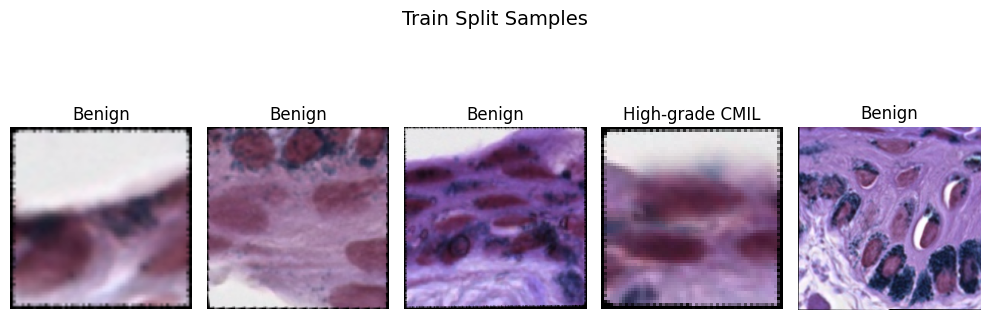


Train Set: Total Patches = 15667
  Benign (0):      8783
  High-grade (1):  6884

Validation Set: Total Patches = 5991
  Benign (0):      1980
  High-grade (1):  4011

Test Set: Total Patches = 7606
  Benign (0):      1567
  High-grade (1):  6039

Train Set: Total Patches = 8141
  Benign (0):      3411
  High-grade (1):  4730

Validation Set: Total Patches = 3054
  Benign (0):      784
  High-grade (1):  2270

Test Set: Total Patches = 3416
  Benign (0):      666
  High-grade (1):  2750

Train Set: Total Patches = 9705
  Benign (0):      4243
  High-grade (1):  5462

Validation Set: Total Patches = 3746
  Benign (0):      1104
  High-grade (1):  2642

Test Set: Total Patches = 4166
  Benign (0):      616
  High-grade (1):  3550


In [20]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(he_train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      he_train_meta)
print_meta_stats("Validation", he_val_meta)
print_meta_stats("Test",       he_test_meta)


print_meta_stats("Train",      sox10_train_meta)
print_meta_stats("Validation", sox10_val_meta)
print_meta_stats("Test",       sox10_test_meta)

print_meta_stats("Train",      melan_train_meta)
print_meta_stats("Validation", melan_val_meta)
print_meta_stats("Test",       melan_test_meta)



**8) Ensemble Evaluation**


--- Initializing Models ---
✅ HE model weights loaded from /content/drive/MyDrive/melan/6_10_he_best_weights.pth
✅ SOX10 model weights loaded from /content/drive/MyDrive/melan/sox10_best_model.pth
✅ MELAN model weights loaded from /content/drive/MyDrive/melan/final_trained_model_2.5.pth

--- Pre-scanning DataLoaders to Collect All Test Case IDs ---


Scanning melan loader: 100%|██████████| 2166/2166 [00:45<00:00, 47.59it/s]


Found 14 unique test cases across all loaders.

--- Running Inference for each model ---


Inference on he patches: 100%|██████████| 3914/3914 [07:02<00:00,  9.25it/s]


Completed inference for he.


Inference on sox10 patches: 100%|██████████| 1797/1797 [06:58<00:00,  4.29it/s]


Completed inference for sox10.


Inference on melan patches: 100%|██████████| 2166/2166 [06:01<00:00,  5.99it/s]


Completed inference for melan.

--- Performing Case-Level Majority Voting ---

=== Ensemble Case-Level Performance ===
Accuracy      : 0.7857
Precision     : 0.7778
Recall        : 0.8750
F1 Score      : 0.8235

Classification Report (Ensemble):
                 precision    recall  f1-score   support

         Benign       0.80      0.67      0.73         6
High-grade CMIL       0.78      0.88      0.82         8

       accuracy                           0.79        14
      macro avg       0.79      0.77      0.78        14
   weighted avg       0.79      0.79      0.78        14



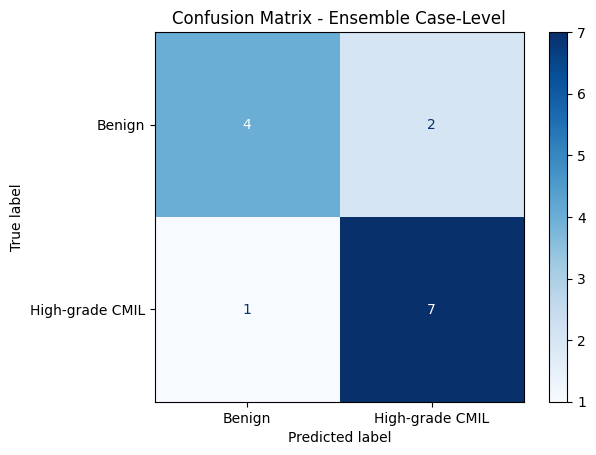


--- Ensemble Evaluation Complete ---


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Needed for KimiaNetClassifier
import torchvision.models as models # Needed for models.densenet121
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import gc # For garbage collection

# IMPORTANT: Ensure all necessary helper functions and classes (KimiaNetClassifier,
# PatchDataset, replace_bn_with_gn, collate_fn_pad, BucketBatchSampler,
# make_boundaries_for_buckets, fast_scan, build_metadata, labels_map,
# and all CONFIG dicts and test_loaders) are defined and accessible in your environment
# before running this code block, as this block only contains the ensemble function
# and the main execution calls.

# Placeholder definitions for classes/functions that are assumed to be defined elsewhere
# You do NOT need to run this if you have them defined. This is just for rendering.
# class KimiaNetClassifier(nn.Module):
#     def __init__(self, num_classes=2, use_groupnorm=True, dropout_rate=0.0): pass
#     def forward(self, x): return x
# def replace_bn_with_gn(module, num_groups=32): pass
# class PatchDataset(Dataset):
#     def __init__(self, meta_df, labels_map, transform=None): pass
#     def __len__(self) -> int: return 0
#     def __getitem__(self, idx: int): return None, None, None
# def collate_fn_pad(batch): return None, None, None
# class BucketBatchSampler(Sampler):
#     def __init__(self, data_source_sizes, batch_size, boundaries, shuffle=True): pass
#     def __iter__(self): return iter([])
#     def __len__(self): return 0
# def make_boundaries_for_buckets(sizes, n_buckets): return []
# def fast_scan(root, max_retries=3, backoff=1.5): return []
# def build_metadata(image_folder, all_cases, meta_csv, stain, force_rebuild=False, min_width=0, max_width=float('inf'), num_workers=4): return pd.DataFrame()
# def move_batch_to_device(images, labels, device): return images, labels

# --- Ensemble Evaluation Function (FIXED KeyError) ---
def evaluate_ensemble_case_level(
    he_model, he_test_loader, he_config, he_threshold,
    sox10_model, sox10_test_loader, sox10_config, sox10_threshold,
    melan_model, melan_test_loader, melan_config, melan_threshold,
    labels_map # Overall labels map for true case labels
):
    """
    Evaluates an ensemble of three models (HE, SOX10, MELAN) using case-level majority voting.

    Args:
        he_model (nn.Module): The HE model instance.
        he_test_loader (DataLoader): DataLoader for HE test data.
        he_config (dict): Configuration for the HE model.
        he_threshold (float): Prediction threshold for the HE model.

        sox10_model (nn.Module): The SOX10 model instance.
        sox10_test_loader (DataLoader): DataLoader for SOX10 test data.
        sox10_config (dict): Configuration for the SOX10 model.
        sox10_threshold (float): Prediction threshold for the SOX10 model.

        melan_model (nn.Module): The MELAN model instance.
        melan_test_loader (DataLoader): DataLoader for MELAN test data.
        melan_config (dict): Configuration for the MELAN model.
        melan_threshold (float): Prediction threshold for the MELAN model.

        labels_map (dict): A dictionary mapping case_number (int) to true class label (int).
    """

    # --- PHASE 1: Collect all unique case IDs and their true labels from the actual test loaders ---
    # This ensures we only initialize prediction storage for cases truly present in the test sets.
    all_test_case_ids_found = set()
    true_case_labels_for_ensemble = {} # Store true labels for ensemble evaluation

    print("\n--- Pre-scanning DataLoaders to Collect All Test Case IDs ---")
    loaders_to_scan = {
        'he': he_test_loader,
        'sox10': sox10_test_loader,
        'melan': melan_test_loader
    }

    for stain_name, loader in loaders_to_scan.items():
        if loader:
            for _, labels, cids in tqdm(loader, desc=f"Scanning {stain_name} loader"):
                for i, cid in enumerate(cids):
                    cid_int = int(cid)
                    all_test_case_ids_found.add(cid_int)
                    if cid_int not in true_case_labels_for_ensemble:
                        # Use the label from the DataLoader, but also verify against labels_map
                        # as labels_map is the definitive source for case-level ground truth.
                        if cid_int in labels_map:
                             true_case_labels_for_ensemble[cid_int] = labels_map[cid_int]
                        else:
                             # Fallback: if not in labels_map, use the patch label.
                             # This scenario should ideally not happen for test cases if labels_map is comprehensive.
                             true_case_labels_for_ensemble[cid_int] = labels[i].item()
                             print(f"Warning: Case ID {cid_int} from {stain_name} loader not found in labels_map. Using patch label as true label.")
        else:
            print(f"Skipping scan for {stain_name} due to missing test loader.")

    all_case_ids_sorted = sorted(list(all_test_case_ids_found))
    print(f"Found {len(all_case_ids_sorted)} unique test cases across all loaders.")

    # Initialize prediction storage for these found cases
    case_predictions = {case_id: {'he': [], 'sox10': [], 'melan': []} for case_id in all_case_ids_sorted}

    softmax = nn.Softmax(dim=1)

    # --- Helper to run inference for a single model ---
    def run_inference(model, loader, device, threshold, stain_name):
        model.eval()
        model.to(device)
        with torch.no_grad():
            for images, _, cids in tqdm(loader, desc=f"Inference on {stain_name} patches"): # Labels are not needed here
                images = images.to(device)

                outputs = model(images)
                probabilities = softmax(outputs) # P(class 0), P(class 1)

                # Get binary prediction based on threshold for P(High-grade CMIL), which is index 1
                # If P(High-grade CMIL) >= threshold, predict 1 (High-grade CMIL), else 0 (Benign)
                patch_preds = (probabilities[:, 1] >= threshold).int().cpu().numpy()

                for i, cid in enumerate(cids):
                    cid_int = int(cid)
                    if cid_int in case_predictions: # Only append if case_id was found during pre-scan
                        case_predictions[cid_int][stain_name].append(patch_preds[i])
                    # else:
                        # This case ID was not in our comprehensive test set. This shouldn't happen
                        # if pre-scan is accurate and loaders only contain expected cases.
                        # print(f"Warning: Patch for case {cid_int} from {stain_name} found, but case not in ensemble set.")

                del images, outputs, probabilities, patch_preds # Free memory

        print(f"Completed inference for {stain_name}.")

    # --- PHASE 2: Run Inference for each model ---
    print("\n--- Running Inference for each model ---")
    if he_test_loader:
        run_inference(he_model, he_test_loader, he_config['device'], he_threshold, 'he')
    else:
        print("Skipping HE model inference due to missing test loader.")

    if sox10_test_loader:
        run_inference(sox10_model, sox10_test_loader, sox10_config['device'], sox10_threshold, 'sox10')
    else:
        print("Skipping SOX10 model inference due to missing test loader.")

    if melan_test_loader:
        run_inference(melan_model, melan_test_loader, melan_config['device'], melan_threshold, 'melan')
    else:
        print("Skipping MELAN model inference due to missing test loader.")

    gc.collect() # Clean up memory after all inferences

    # --- PHASE 3: Case-Level Majority Voting ---
    print("\n--- Performing Case-Level Majority Voting ---")
    final_case_preds = []
    final_case_true_labels = []
    cases_with_no_data = [] # Cases that had no patches processed from any stain

    for case_id in all_case_ids_sorted: # Iterate over the comprehensive sorted list of cases
        he_votes = case_predictions[case_id]['he']
        sox10_votes = case_predictions[case_id]['sox10']
        melan_votes = case_predictions[case_id]['melan']

        all_patch_votes_for_case = he_votes + sox10_votes + melan_votes

        if not all_patch_votes_for_case:
            cases_with_no_data.append(case_id)
            continue # Skip cases with no patch data from any stain

        sum_of_ones = sum(all_patch_votes_for_case)
        sum_of_zeros = len(all_patch_votes_for_case) - sum_of_ones

        # Majority voting
        if sum_of_ones > sum_of_zeros:
            case_pred = 1 # High-grade CMIL
        elif sum_of_zeros > sum_of_ones:
            case_pred = 0 # Benign
        else:
            # Tie-breaking: Default to Benign (0) as conservative approach
            case_pred = 0
            # print(f"Tie-vote for case {case_id}. Defaulting to Benign (0). Votes: {sum_of_zeros} (0) vs {sum_of_ones} (1)")

        final_case_preds.append(case_pred)
        # Use the true label collected during the initial scan
        final_case_true_labels.append(true_case_labels_for_ensemble[case_id])

    if cases_with_no_data:
        print(f"Warning: No patch data found for cases: {cases_with_no_data}. These cases will be excluded from ensemble metrics.")

    # Convert to numpy arrays for sklearn metrics
    final_case_true_labels = np.array(final_case_true_labels)
    final_case_preds = np.array(final_case_preds)

    # --- PHASE 4: Evaluate Ensemble Performance ---
    print("\n=== Ensemble Case-Level Performance ===")
    if len(final_case_true_labels) == 0:
        print("No cases to evaluate after ensemble. Check data loading and case lists.")
        return

    ensemble_acc = accuracy_score(final_case_true_labels, final_case_preds)
    ensemble_prec = precision_score(final_case_true_labels, final_case_preds, zero_division=0)
    ensemble_rec = recall_score(final_case_true_labels, final_case_preds, zero_division=0)
    ensemble_f1 = f1_score(final_case_true_labels, final_case_preds, zero_division=0)

    print(f"Accuracy      : {ensemble_acc:.4f}")
    print(f"Precision     : {ensemble_prec:.4f}")
    print(f"Recall        : {ensemble_rec:.4f}")
    print(f"F1 Score      : {ensemble_f1:.4f}")
    print("\nClassification Report (Ensemble):")
    class_names = ["Benign", "High-grade CMIL"]
    print(classification_report(final_case_true_labels, final_case_preds, target_names=class_names, zero_division=0))

    # Plot Confusion Matrix for Ensemble
    cm = confusion_matrix(final_case_true_labels, final_case_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Ensemble Case-Level")
    plt.show()


# --- Main Execution Block (Only the part you want to run) ---
# IMPORTANT: Make sure these variables are defined and populated in your environment
# from the code you already ran:
# - KimiaNetClassifier (the class definition)
# - he_CONFIG, sox10_CONFIG, melan_CONFIG (the dictionaries)
# - he_test_loader, sox10_test_loader, melan_test_loader (the DataLoader instances)
# - labels_map (the dictionary mapping case_number to true label)

# Also ensure `torch.nn`, `torchvision.models`, `os`, `pandas`, `numpy`, `sklearn.metrics`, `matplotlib.pyplot`, `tqdm`, `gc` are imported.

print("\n--- Initializing Models ---")

# HE Model
he_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True, dropout_rate=0.0).to(he_CONFIG['device'])
he_model_path = "/content/drive/MyDrive/melan/6_10_he_best_weights.pth"
if os.path.exists(he_model_path):
    he_model.load_state_dict(torch.load(he_model_path, map_location=he_CONFIG['device']))
    print(f"✅ HE model weights loaded from {he_model_path}")
else:
    print(f"❌ HE model weights NOT FOUND at {he_model_path}. Evaluation might be inaccurate.")

# SOX10 Model
sox10_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True, dropout_rate=0.0).to(sox10_CONFIG['device'])
sox10_model_path = "/content/drive/MyDrive/melan/sox10_best_model.pth"
if os.path.exists(sox10_model_path):
    sox10_model.load_state_dict(torch.load(sox10_model_path, map_location=sox10_CONFIG['device']))
    print(f"✅ SOX10 model weights loaded from {sox10_model_path}")
else:
    print(f"❌ SOX10 model weights NOT FOUND at {sox10_model_path}. Evaluation might be inaccurate.")

# MELAN Model
melan_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True, dropout_rate=0.25).to(melan_CONFIG['device'])
melan_model_path = "/content/drive/MyDrive/melan/final_trained_model_melan.pth"
if os.path.exists(melan_model_path):
    melan_model.load_state_dict(torch.load(melan_model_path, map_location=melan_CONFIG['device']))
    print(f"✅ MELAN model weights loaded from {melan_model_path}")
else:
    print(f"❌ MELAN model weights NOT FOUND at {melan_model_path}. Evaluation might be inaccurate.")

# Run the ensemble evaluation
evaluate_ensemble_case_level(
    he_model, he_test_loader, he_CONFIG, 0.22, # HE model and its params
    sox10_model, sox10_test_loader, sox10_CONFIG, 0.31, # SOX10 model and its params
    melan_model, melan_test_loader, melan_CONFIG, 0.23, # MELAN model and its params
    labels_map # Overall labels map for true case labels
)

print("\n--- Ensemble Evaluation Complete ---")



--- Initializing Models ---
DenseNet-121 BatchNorm layers replaced with GroupNorm.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ HE model weights loaded from /content/drive/MyDrive/melan/6_10_he_best_weights.pth
DenseNet-121 BatchNorm layers replaced with GroupNorm.
✅ SOX10 model weights loaded from /content/drive/MyDrive/melan/sox10_best_model.pth
DenseNet-121 BatchNorm layers replaced with GroupNorm.
✅ MELAN model weights loaded from /content/drive/MyDrive/melan/final_trained_model_2.5.pth

--- Pre-scanning DataLoaders to Collect All Test Case IDs ---


Scanning melan loader: 100%|██████████| 2166/2166 [00:45<00:00, 47.10it/s]


Found 14 unique test cases across all loaders.

--- Running Inference for each model ---


Inference on he patches: 100%|██████████| 3914/3914 [02:26<00:00, 26.78it/s]


Completed inference for he.


Inference on sox10 patches: 100%|██████████| 1797/1797 [01:40<00:00, 17.96it/s]


Completed inference for sox10.


Inference on melan patches: 100%|██████████| 2166/2166 [02:03<00:00, 17.49it/s]


Completed inference for melan.

--- Performing Case-Level Majority Voting and Percent Correct Calculation ---

=== Ensemble Case-Level Performance ===
Accuracy      : 0.7857
Precision     : 0.7778
Recall        : 0.8750
F1 Score      : 0.8235

Classification Report (Ensemble):
                 precision    recall  f1-score   support

         Benign       0.80      0.67      0.73         6
High-grade CMIL       0.78      0.88      0.82         8

       accuracy                           0.79        14
      macro avg       0.79      0.77      0.78        14
   weighted avg       0.79      0.79      0.78        14



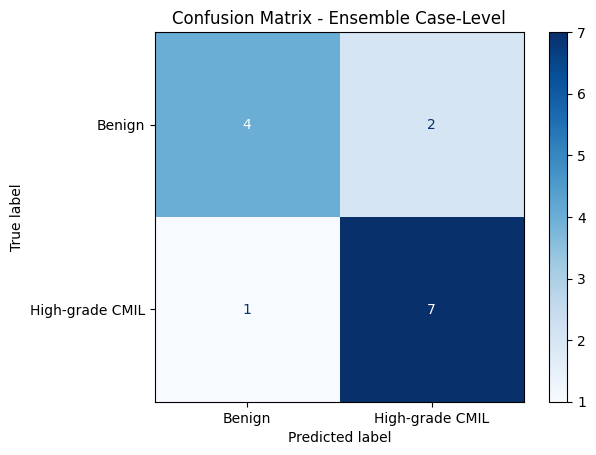


--- Percent Correct Votes Per Case (Summary) ---
Average Percent Correct Votes: 63.59%
Min Percent Correct Votes    : 3.33%
Max Percent Correct Votes    : 93.99%
Median Percent Correct Votes : 72.31%
Std Dev Percent Correct Votes: 26.28%

--- Percent Correct Votes Per Case (Detailed) ---
Case 14: 56.00% correct votes (True Label: High-grade CMIL)
Case 15: 44.17% correct votes (True Label: High-grade CMIL)
Case 19: 83.16% correct votes (True Label: High-grade CMIL)
Case 23: 81.48% correct votes (True Label: Benign)
Case 27: 79.77% correct votes (True Label: Benign)
Case 38: 93.99% correct votes (True Label: High-grade CMIL)
Case 45: 13.51% correct votes (True Label: Benign)
Case 46: 3.33% correct votes (True Label: Benign)
Case 50: 89.43% correct votes (True Label: High-grade CMIL)
Case 78: 53.79% correct votes (True Label: Benign)
Case 83: 70.13% correct votes (True Label: High-grade CMIL)
Case 84: 66.86% correct votes (True Label: High-grade CMIL)
Case 85: 74.48% correct votes (True 

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import gc

# Helper function to replace BatchNorm with GroupNorm
def replace_bn_with_gn(module, num_groups=32):
    """
    Recursively replaces all BatchNorm layers in a module with GroupNorm layers.
    Args:
        module (nn.Module): The module to modify.
        num_groups (int): The number of groups for GroupNorm.
    Returns:
        nn.Module: The modified module.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            # Create a GroupNorm layer with the same number of channels
            # Ensure num_groups is not greater than num_channels
            num_channels = child.num_features
            gn_groups = min(num_groups, num_channels) # Use min to avoid error if num_channels < num_groups
            setattr(module, name, nn.GroupNorm(gn_groups, num_channels))
        else:
            replace_bn_with_gn(child, num_groups) # Recurse for sub-modules
    return module

# Definition of KimiaNetClassifier (Revised to match your expected structure)
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2, use_groupnorm=True, dropout_rate=0.0):
        super(KimiaNetClassifier, self).__init__()

        # Load the base DenseNet121 model without pre-trained ImageNet weights
        # This assumes your .pth files contain the weights for the features directly.
        base = models.densenet121(pretrained=False)

        # Optionally replace BatchNorm with GroupNorm in the base feature extractor
        if use_groupnorm:
            # Apply GN to the base model's modules
            base = replace_bn_with_gn(base)
            print("DenseNet-121 BatchNorm layers replaced with GroupNorm.")

        # The feature extraction part of DenseNet (accessed directly)
        self.features = base.features

        # Add a Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0 else nn.Identity()

        # The final classification layer (DenseNet121's classifier input features is 1024)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Pass input through the DenseNet feature extractor
        x = self.features(x)

        # Apply ReLU activation and adaptive average pooling
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)

        # Apply dropout before the final classification layer
        x = self.dropout(x)

        # Pass through the final classification layer
        out = self.classifier(x)
        return out


# --- Ensemble Evaluation Function (FIXED KeyError + ADDED PERCENT CORRECT) ---
def evaluate_ensemble_case_level(
    he_model, he_test_loader, he_config, he_threshold,
    sox10_model, sox10_test_loader, sox10_config, sox10_threshold,
    melan_model, melan_test_loader, melan_config, melan_threshold,
    labels_map # Overall labels map for true case labels
):
    """
    Evaluates an ensemble of three models (HE, SOX10, MELAN) using case-level majority voting.
    Includes calculation of "percent correct" votes for each case.

    Args:
        he_model (nn.Module): The HE model instance.
        he_test_loader (DataLoader): DataLoader for HE test data.
        he_config (dict): Configuration for the HE model.
        he_threshold (float): Prediction threshold for the HE model.

        sox10_model (nn.Module): The SOX10 model instance.
        sox10_test_loader (DataLoader): DataLoader for SOX10 test data.
        sox10_config (dict): Configuration for the SOX10 model.
        sox10_threshold (float): Prediction threshold for the SOX10 model.

        melan_model (nn.Module): The MELAN model instance.
        melan_test_loader (DataLoader): DataLoader for MELAN test data.
        melan_config (dict): Configuration for the MELAN model.
        melan_threshold (float): Prediction threshold for the MELAN model.

        labels_map (dict): A dictionary mapping case_number (int) to true class label (int).
    """

    # --- PHASE 1: Collect all unique case IDs and their true labels from the actual test loaders ---
    all_test_case_ids_found = set()
    true_case_labels_for_ensemble = {}

    print("\n--- Pre-scanning DataLoaders to Collect All Test Case IDs ---")
    loaders_to_scan = {
        'he': he_test_loader,
        'sox10': sox10_test_loader,
        'melan': melan_test_loader
    }

    for stain_name, loader in loaders_to_scan.items():
        if loader:
            for _, labels, cids in tqdm(loader, desc=f"Scanning {stain_name} loader"):
                for i, cid in enumerate(cids):
                    cid_int = int(cid)
                    all_test_case_ids_found.add(cid_int)
                    if cid_int not in true_case_labels_for_ensemble:
                        if cid_int in labels_map:
                             true_case_labels_for_ensemble[cid_int] = labels_map[cid_int]
                        else:
                             true_case_labels_for_ensemble[cid_int] = labels[i].item()
                             print(f"Warning: Case ID {cid_int} from {stain_name} loader not found in labels_map. Using patch label as true label.")
        else:
            print(f"Skipping scan for {stain_name} due to missing test loader.")

    all_case_ids_sorted = sorted(list(all_test_case_ids_found))
    print(f"Found {len(all_case_ids_sorted)} unique test cases across all loaders.")

    case_predictions = {case_id: {'he': [], 'sox10': [], 'melan': []} for case_id in all_case_ids_sorted}

    softmax = nn.Softmax(dim=1)

    # --- Helper to run inference for a single model ---
    def run_inference(model, loader, device, threshold, stain_name):
        model.eval()
        model.to(device)
        with torch.no_grad():
            for images, _, cids in tqdm(loader, desc=f"Inference on {stain_name} patches"):
                images = images.to(device)

                outputs = model(images)
                probabilities = softmax(outputs)

                patch_preds = (probabilities[:, 1] >= threshold).int().cpu().numpy()

                for i, cid in enumerate(cids):
                    cid_int = int(cid)
                    if cid_int in case_predictions:
                        case_predictions[cid_int][stain_name].append(patch_preds[i])

                del images, outputs, probabilities, patch_preds

        print(f"Completed inference for {stain_name}.")

    # --- PHASE 2: Run Inference for each model ---
    print("\n--- Running Inference for each model ---")
    if he_test_loader:
        run_inference(he_model, he_test_loader, he_config['device'], he_threshold, 'he')
    else:
        print("Skipping HE model inference due to missing test loader.")

    if sox10_test_loader:
        run_inference(sox10_model, sox10_test_loader, sox10_config['device'], sox10_threshold, 'sox10')
    else:
        print("Skipping SOX10 model inference due to missing test loader.")

    if melan_test_loader:
        run_inference(melan_model, melan_test_loader, melan_config['device'], melan_threshold, 'melan')
    else:
        print("Skipping MELAN model inference due to missing test loader.")

    gc.collect()

    # --- PHASE 3: Case-Level Majority Voting & Percent Correct Calculation ---
    print("\n--- Performing Case-Level Majority Voting and Percent Correct Calculation ---")
    final_case_preds = []
    final_case_true_labels = []
    cases_with_no_data = []
    percent_correct_votes_per_case_detailed = {} # Stores percent correct votes for each case

    for case_id in all_case_ids_sorted:
        he_votes = case_predictions[case_id]['he']
        sox10_votes = case_predictions[case_id]['sox10']
        melan_votes = case_predictions[case_id]['melan']

        all_patch_votes_for_case = he_votes + sox10_votes + melan_votes

        if not all_patch_votes_for_case:
            cases_with_no_data.append(case_id)
            continue

        sum_of_ones = sum(all_patch_votes_for_case)
        sum_of_zeros = len(all_patch_votes_for_case) - sum_of_ones

        if sum_of_ones > sum_of_zeros:
            case_pred = 1
        elif sum_of_zeros > sum_of_ones:
            case_pred = 0
        else:
            case_pred = 0 # Tie-breaking: Default to Benign (0)

        final_case_preds.append(case_pred)
        current_true_label = true_case_labels_for_ensemble[case_id] # Get the true label for this case
        final_case_true_labels.append(current_true_label)

        # Calculate percent correct votes for this case (matching the TRUE case label)
        correct_votes_count = sum(1 for vote in all_patch_votes_for_case if vote == current_true_label)
        total_votes_count = len(all_patch_votes_for_case)
        if total_votes_count > 0:
            percent_correct = (correct_votes_count / total_votes_count) * 100
            percent_correct_votes_per_case_detailed[case_id] = percent_correct
        else:
            percent_correct_votes_per_case_detailed[case_id] = np.nan # Should not happen if all_patch_votes_for_case is not empty

    if cases_with_no_data:
        print(f"Warning: No patch data found for cases: {cases_with_no_data}. These cases will be excluded from ensemble metrics.")

    final_case_true_labels = np.array(final_case_true_labels)
    final_case_preds = np.array(final_case_preds)

    # --- PHASE 4: Evaluate Ensemble Performance ---
    print("\n=== Ensemble Case-Level Performance ===")
    if len(final_case_true_labels) == 0:
        print("No cases to evaluate after ensemble. Check data loading and case lists.")
        return

    ensemble_acc = accuracy_score(final_case_true_labels, final_case_preds)
    ensemble_prec = precision_score(final_case_true_labels, final_case_preds, zero_division=0)
    ensemble_rec = recall_score(final_case_true_labels, final_case_preds, zero_division=0)
    ensemble_f1 = f1_score(final_case_true_labels, final_case_preds, zero_division=0)

    print(f"Accuracy      : {ensemble_acc:.4f}")
    print(f"Precision     : {ensemble_prec:.4f}")
    print(f"Recall        : {ensemble_rec:.4f}")
    print(f"F1 Score      : {ensemble_f1:.4f}")
    print("\nClassification Report (Ensemble):")
    class_names = ["Benign", "High-grade CMIL"]
    print(classification_report(final_case_true_labels, final_case_preds, target_names=class_names, zero_division=0))

    # Plot Confusion Matrix for Ensemble
    cm = confusion_matrix(final_case_true_labels, final_case_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Ensemble Case-Level")
    plt.show()

    # --- Display Percent Correct Votes ---
    if percent_correct_votes_per_case_detailed:
        all_percent_correct_values = list(percent_correct_votes_per_case_detailed.values())
        print("\n--- Percent Correct Votes Per Case (Summary) ---")
        print(f"Average Percent Correct Votes: {np.mean(all_percent_correct_values):.2f}%")
        print(f"Min Percent Correct Votes    : {np.min(all_percent_correct_values):.2f}%")
        print(f"Max Percent Correct Votes    : {np.max(all_percent_correct_values):.2f}%")
        print(f"Median Percent Correct Votes : {np.median(all_percent_correct_values):.2f}%")
        print(f"Std Dev Percent Correct Votes: {np.std(all_percent_correct_values):.2f}%")

        print("\n--- Percent Correct Votes Per Case (Detailed) ---")
        for case_id in sorted(percent_correct_votes_per_case_detailed.keys()):
            true_label_str = class_names[true_case_labels_for_ensemble[case_id]]
            print(f"Case {case_id}: {percent_correct_votes_per_case_detailed[case_id]:.2f}% correct votes (True Label: {true_label_str})")
    else:
        print("\nNo percent correct votes to display (no cases evaluated).")


# --- Main Execution Block ---
# IMPORTANT: Make sure these variables are defined and populated in your environment
# from the code you already ran:
# - he_CONFIG, sox10_CONFIG, melan_CONFIG (the dictionaries)
# - he_test_loader, sox10_test_loader, melan_test_loader (the DataLoader instances)
# - labels_map (the dictionary mapping case_number to true label)

print("\n--- Initializing Models ---")

# HE Model
he_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True, dropout_rate=0.0).to(he_CONFIG['device'])
he_model_path = "/content/drive/MyDrive/melan/6_10_he_best_weights.pth"
if os.path.exists(he_model_path):
    he_model.load_state_dict(torch.load(he_model_path, map_location=he_CONFIG['device']))
    print(f"✅ HE model weights loaded from {he_model_path}")
else:
    print(f"❌ HE model weights NOT FOUND at {he_model_path}. Evaluation might be inaccurate.")

# SOX10 Model
sox10_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True, dropout_rate=0.0).to(sox10_CONFIG['device'])
sox10_model_path = "/content/drive/MyDrive/melan/sox10_best_model.pth"
if os.path.exists(sox10_model_path):
    sox10_model.load_state_dict(torch.load(sox10_model_path, map_location=sox10_CONFIG['device']))
    print(f"✅ SOX10 model weights loaded from {sox10_model_path}")
else:
    print(f"❌ SOX10 model weights NOT FOUND at {sox10_model_path}. Evaluation might be inaccurate.")

# MELAN Model
melan_model = KimiaNetClassifier(num_classes=2, use_groupnorm=True, dropout_rate=0.25).to(melan_CONFIG['device'])
melan_model_path = "/content/drive/MyDrive/melan/final_trained_model_melan.pth"
if os.path.exists(melan_model_path):
    melan_model.load_state_dict(torch.load(melan_model_path, map_location=melan_CONFIG['device']))
    print(f"✅ MELAN model weights loaded from {melan_model_path}")
else:
    print(f"❌ MELAN model weights NOT FOUND at {melan_model_path}. Evaluation might be inaccurate.")

# Run the ensemble evaluation
evaluate_ensemble_case_level(
    he_model, he_test_loader, he_CONFIG, 0.22, # HE model and its params
    sox10_model, sox10_test_loader, sox10_CONFIG, 0.31, # SOX10 model and its params
    melan_model, melan_test_loader, melan_CONFIG, 0.23, # MELAN model and its params
    labels_map # Overall labels map for true case labels
)

print("\n--- Ensemble Evaluation Complete ---")